In [ ]:
!pip install datasets
!pip install timm==0.6.13

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import timm
from tqdm import tqdm
import cv2

In [3]:
# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 데이터셋 준비

In [4]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# 학습 이미지 변환 설정 - 데이터 증강 (에폭마다 변경)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 80~100% 크기로 랜덤 크롭
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 플립
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변화
    transforms.RandomRotation(degrees=15),  # 랜덤 회전 (±15도)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# 데이터셋 설정
class Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image'].convert('RGB')
        label = self.dataset[idx]['labels']

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# 데이터셋 로드
dataset = load_dataset('microsoft/cats_vs_dogs', split='train') # 허깅페이스 데이터셋 변경 가능
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)

# 데이터셋 분할 (80% Train, 20% Test)
train_dataset = Dataset(dataset_split['train'], transform=train_transform)
test_dataset = Dataset(dataset_split['test'], transform=transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [7]:
# # 커스텀 데이터 사용 시

# data = 'data'  # 커스텀 데이터가 있는 폴더 (해당 폴더 안에 각 클래스 별로 폴더 생성)

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = f"/content/drive/MyDrive/{data}"
# dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# # 데이터셋 분할 (80% Train, 20% Test)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # DataLoader 설정
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [8]:
print(f"총 데이터 개수: {len(dataset)}")
print(f"학습 데이터 개수: {len(train_dataset)}")
print(f"테스트 데이터 개수: {len(test_dataset)}")

총 데이터 개수: 23410
학습 데이터 개수: 18728
테스트 데이터 개수: 4682


# 모델 준비 (DeiT Model)

In [9]:
# 사전학습 모델과 스크래치 모델 생성
pretrained_model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=2) # deit_base_patch16_224
scratch_model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=2)

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


In [10]:
# 모델 구조 확인
def print_model_structure(model):
    printed_blocks = set()
    for name, module in model.named_modules():
        if 'blocks' in name:
            parts = name.split('.')
            if len(parts) > 1:
                block_num = parts[1]
                if block_num == '0':
                    print(name)
                elif block_num not in printed_blocks:
                    print(f"blocks.{block_num}")
                    printed_blocks.add(block_num)
        else:
            print(name)

print_model_structure(pretrained_model)


patch_embed
patch_embed.proj
patch_embed.norm
pos_drop
norm_pre
blocks.0
blocks.0.norm1
blocks.0.attn
blocks.0.attn.qkv
blocks.0.attn.attn_drop
blocks.0.attn.proj
blocks.0.attn.proj_drop
blocks.0.ls1
blocks.0.drop_path1
blocks.0.norm2
blocks.0.mlp
blocks.0.mlp.fc1
blocks.0.mlp.act
blocks.0.mlp.drop1
blocks.0.mlp.fc2
blocks.0.mlp.drop2
blocks.0.ls2
blocks.0.drop_path2
blocks.1
blocks.2
blocks.3
blocks.4
blocks.5
blocks.6
blocks.7
blocks.8
blocks.9
blocks.10
blocks.11
norm
fc_norm
head


# 모델 학습

In [11]:
# Training 함수
def train_model(model, train_loader, test_loader, num_epochs, model_type='pretrained'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss() # 크로스엔트로피 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # 옵티마이저 설정

    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images) # 이미지 입력 후 모델 추론
            loss = criterion(outputs, labels) # 추론값과 정답의 크로스엔트로피를 통한 손실 계산
            loss.backward() # 역전파
            optimizer.step() # 옵티마이저로 업데이트

            running_loss += loss.item() # 손실값 기록

        # Test (Validation) 함수
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # 파라미터 동결
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f'{model_type} Model - Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.2f}%')

    return model

In [12]:
# 모델 학습
print("Training Pretrained Model:")
pretrained_model = train_model(pretrained_model, train_loader, test_loader,3)

print("\nTraining From-Scratch Model:")
scratch_model = train_model(scratch_model, train_loader, test_loader,3)

Training Pretrained Model:


Epoch 1/3: 100%|██████████| 586/586 [03:19<00:00,  2.94it/s]


pretrained Model - Epoch 1 Loss: 0.0807, Acc: 98.21%


Epoch 2/3: 100%|██████████| 586/586 [03:16<00:00,  2.98it/s]


pretrained Model - Epoch 2 Loss: 0.0582, Acc: 97.48%


Epoch 3/3: 100%|██████████| 586/586 [03:14<00:00,  3.02it/s]


pretrained Model - Epoch 3 Loss: 0.0527, Acc: 97.78%

Training From-Scratch Model:


Epoch 1/3: 100%|██████████| 586/586 [03:20<00:00,  2.92it/s]


pretrained Model - Epoch 1 Loss: 0.6822, Acc: 57.65%


Epoch 2/3: 100%|██████████| 586/586 [03:23<00:00,  2.88it/s]


pretrained Model - Epoch 2 Loss: 0.6506, Acc: 62.22%


Epoch 3/3: 100%|██████████| 586/586 [03:23<00:00,  2.87it/s]


pretrained Model - Epoch 3 Loss: 0.6307, Acc: 63.61%


In [13]:
# 어텐션 롤아웃 (각 레이어의 어텐션 값 평균 구함함)
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean", discard_ratio=0.5):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        self.attentions = []

        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

    def get_attention(self, module, input, output):
        self.attentions.append(output.detach().cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return self.rollout(self.attentions)

    def rollout(self, attentions):
        result = torch.eye(attentions[0].size(-1), device=attentions[0].device)
        for attention in attentions:
            attention_heads_fused = attention.mean(axis=1)  # Head 평균
            attention_heads_fused = torch.nn.functional.softmax(attention_heads_fused, dim=-1)  # 부드럽게 변환

            # Identity 행렬 추가하여 self-attention 보존
            I = torch.eye(attention_heads_fused.size(-1), device=attention_heads_fused.device)
            a = (attention_heads_fused + I) / 2
            a = a / a.sum(dim=-1, keepdim=True)  # 정규화

            result = torch.matmul(a, result)

        mask = result[0, 0, 1:]  # CLS 토큰 제외
        width = int(mask.size(-1)**0.5)
        print("patch size: 16")
        print("width size:",width)
        mask = mask.reshape(width, width).numpy()
        mask = mask / np.max(mask)
        return mask

In [14]:
def visualize_attention(model, test_sample, title):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    rollout = VITAttentionRollout(model)
    attention_mask = rollout(test_sample.unsqueeze(0).to(device))

    # 이미지 역변환
    inv_transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                            std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])

    img = inv_transform(test_sample.cpu())

    # 패치 해상도 향상
    # mask = cv2.resize(attention_mask, (224, 224), interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(attention_mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.title(f'{title} Attention Map')
    plt.show()

patch size: 16
width size: 14


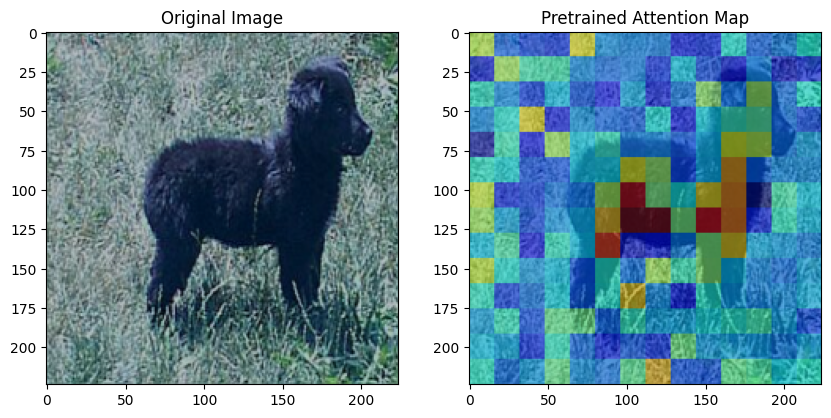

patch size: 16
width size: 14


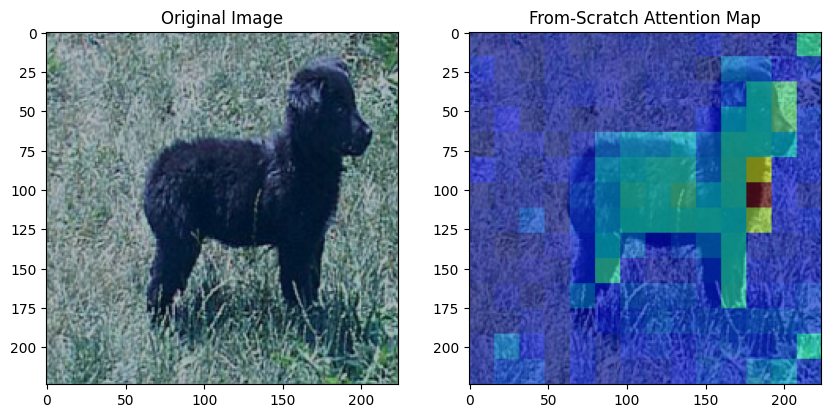

In [15]:
# 테스트 데이터로 예측 및 시각화
test_sample, test_label = test_dataset[0]
visualize_attention(pretrained_model, test_sample, 'Pretrained')
visualize_attention(scratch_model, test_sample,'From-Scratch')

patch size: 16
width size: 14


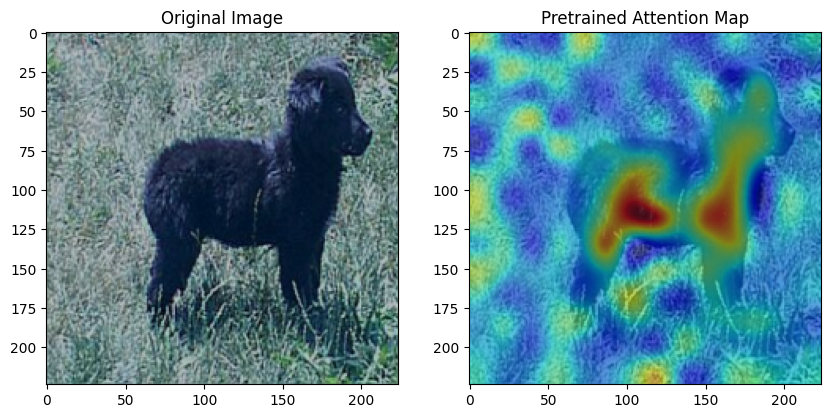

patch size: 16
width size: 14


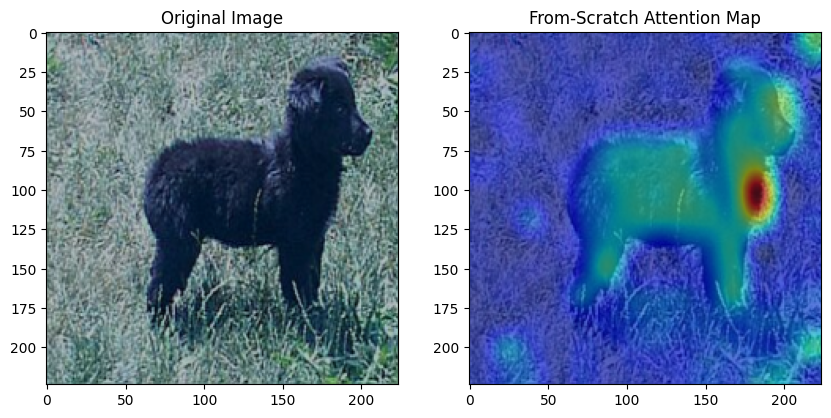

In [18]:
def visualize_attention(model, test_sample, title):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    rollout = VITAttentionRollout(model)
    attention_mask = rollout(test_sample.unsqueeze(0).to(device))

    # 이미지 역변환
    inv_transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                            std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])

    img = inv_transform(test_sample.cpu())

    # 패치 해상도 향상
    mask = cv2.resize(attention_mask, (224, 224), interpolation=cv2.INTER_CUBIC)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.title(f'{title} Attention Map')
    plt.show()
visualize_attention(pretrained_model, test_sample, 'Pretrained')
visualize_attention(scratch_model, test_sample,'From-Scratch')

In [ ]:
# 모델 저장
from google.colab import drive
drive.mount('/content/drive')

def save_model(model, path):
    torch.save(model.state_dict(), f"/content/drive/MyDrive/{path}")

# 학습 후 호출
save_model(pretrained_model, 'vit_pretrained.pth')
print("Saved Pre-train + Fine-tuning Model")
save_model(scratch_model, 'vit_scratch.pth')
print("Saved Scratch + Fine-tuning Model")